<a href="https://colab.research.google.com/github/mahesh-babu-chittem/Machine-Learning-MaheshBabuChittem/blob/main/Lab6_AP23110010084_LinearRegressionEnd_to_End.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ================================
# 0) Install & Imports (safe)
# ================================
import sys, subprocess
def pip_install(pkg): subprocess.run([sys.executable, "-m", "pip", "install", "-q", pkg], check=False)

pip_install("pandas>=1.5")
pip_install("numpy>=1.23")
pip_install("matplotlib>=3.7")
pip_install("scikit-learn>=1.3")
pip_install("statsmodels>=0.14")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan

%matplotlib inline


In [2]:
# ============================================================
# 1) Load + load dataset (California Housing; ready-to-run)
#    (Optional gdown CSV block is commented below)
# ============================================================
housing = fetch_california_housing(as_frame=True)
df = housing.frame.copy()
target = "MedHouseVal"

print("✅ Loaded:", df.shape)
df.head()


✅ Loaded: (20640, 9)


,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422


In [3]:
# ============================================================
# 2) Inspect + clean data (simple)
# ============================================================
print("Columns:", df.columns.tolist())
print("\nDtypes:\n", df.dtypes)
print("\nMissing values:\n", df.isna().sum())

before = df.shape[0]
df = df.drop_duplicates().reset_index(drop=True)
print("\nDropped duplicates:", before - df.shape[0])

# (Example sanity filters; adjust as needed)
# For housing data, values are positive and reasonable bounds:
num_cols = df.select_dtypes(include=np.number).columns
for c in num_cols:
    df = df[df[c].notna()]

print("✅ Cleaned shape:", df.shape)


Columns: ['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude', 'MedHouseVal']

Dtypes:
 MedInc         float64
HouseAge       float64
AveRooms       float64
AveBedrms      float64
Population     float64
AveOccup       float64
Latitude       float64
Longitude      float64
MedHouseVal    float64
dtype: object

Missing values:
 MedInc         0
HouseAge       0
AveRooms       0
AveBedrms      0
Population     0
AveOccup       0
Latitude       0
Longitude      0
MedHouseVal    0
dtype: int64

Dropped duplicates: 0
✅ Cleaned shape: (20640, 9)


In [4]:
# ============================================================
# 3) VIF check — multicollinearity on cleaned numeric X
#    (Don't include the target in VIF)
# ============================================================
X_vif = df.drop(columns=[target])
# Ensure DataFrame and add constant
X_vif = sm.add_constant(X_vif)

vif_rows = []
for i in range(1, X_vif.shape[1]):  # skip constant at col 0
    vif_rows.append({
        "feature": X_vif.columns[i],
        "VIF": variance_inflation_factor(X_vif.values, i)
    })
vif_df = pd.DataFrame(vif_rows).sort_values("VIF", ascending=False)
vif_df


,feature,VIF
6,Latitude,9.297624
7,Longitude,8.962263
2,AveRooms,8.342786
3,AveBedrms,6.994995
0,MedInc,2.501295
1,HouseAge,1.241254
4,Population,1.138125
5,AveOccup,1.008324


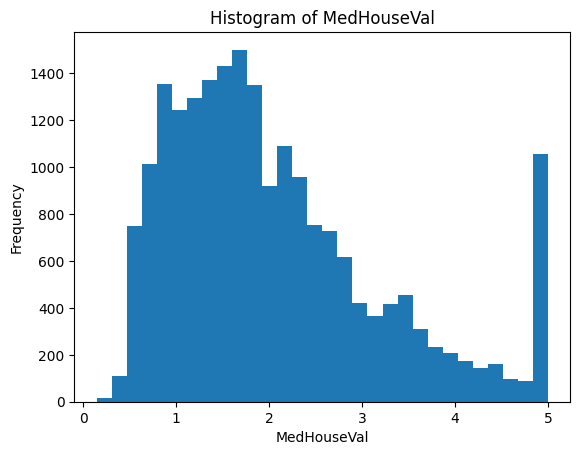

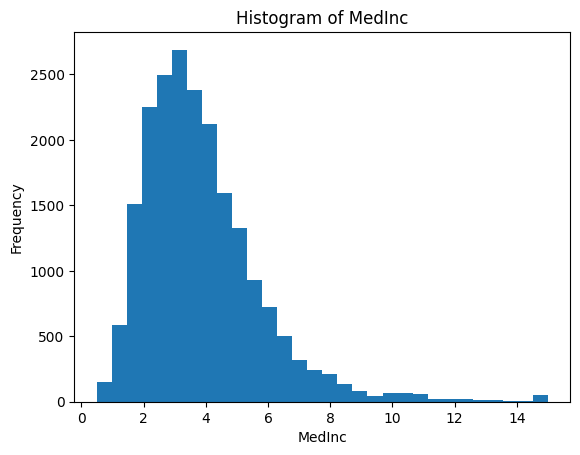

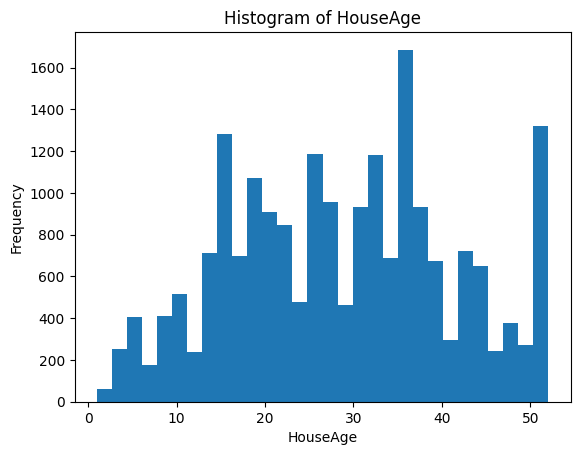

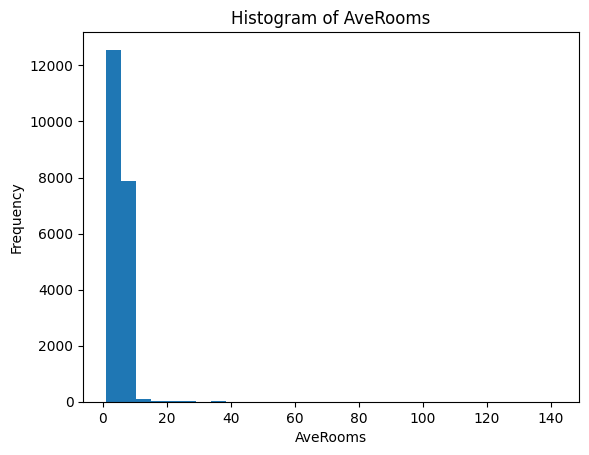

In [5]:
# ============================================================
# 4) Univariate plots (histograms)
# ============================================================
# Target
plt.figure()
df[target].plot(kind="hist", bins=30, title=f"Histogram of {target}")
plt.xlabel(target); plt.ylabel("Frequency")
plt.show()

# A few numeric features
for col in df.drop(columns=[target]).select_dtypes(include=np.number).columns[:3]:
    plt.figure()
    df[col].plot(kind="hist", bins=30, title=f"Histogram of {col}")
    plt.xlabel(col); plt.ylabel("Frequency")
    plt.show()


In [6]:
# ============================================================
# 5) Class balancing / binning (optional)
#    Here: create quantile bins of the target and (optionally)
#    upsample to balance rare ranges. We'll just inspect counts
#    and keep original df by default.
# ============================================================
bins = 3
df_tmp = df.copy()
df_tmp["target_bin"] = pd.qcut(df_tmp[target], q=bins, labels=[f"bin_{i}" for i in range(bins)])

print("Target-bin counts (no resampling):")
print(df_tmp["target_bin"].value_counts())

Target-bin counts (no resampling):
target_bin
bin_0    6884
bin_2    6880
bin_1    6876
Name: count, dtype: int64


In [7]:
# ============================================================
# 6) Choose target & features (prepare X, y)
# ============================================================
y = df[target]
X = df.drop(columns=[target])

print("X shape:", X.shape, "| y shape:", y.shape)


X shape: (20640, 8) | y shape: (20640,)


In [8]:
# ============================================================
# 7) Train/Test split (explicit step)
# ============================================================
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42
)
print("Train shapes:", X_train.shape, y_train.shape)
print("Test shapes:", X_test.shape, y_test.shape)


Train shapes: (16512, 8) (16512,)
Test shapes: (4128, 8) (4128,)


In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Features & target
X = df.drop(columns=[target])
y = df[target]

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Normalization after splitting
scaler = MinMaxScaler()
X_train_norm = scaler.fit_transform(X_train)   # fit on train
X_test_norm = scaler.transform(X_test)         # transform test

print("✅ Shapes:", X_train_norm.shape, X_test_norm.shape)
print("🔎 Example feature range after normalization:")
print("Train min:", X_train_norm.min(axis=0)[:5])
print("Train max:", X_train_norm.max(axis=0)[:5])


✅ Shapes: (16512, 8) (4128, 8)
🔎 Example feature range after normalization:
Train min: [0. 0. 0. 0. 0.]
Train max: [1. 1. 1. 1. 1.]


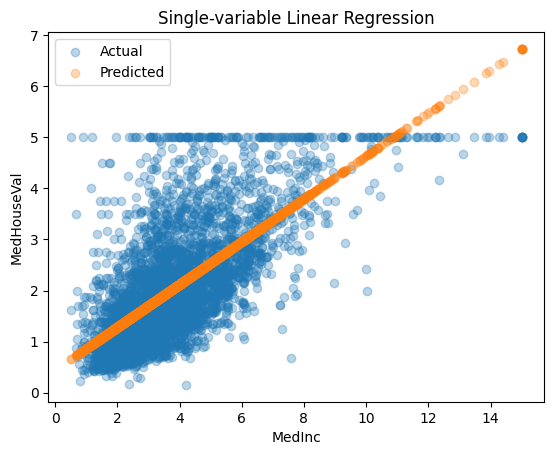

Single-var R²: 0.45885918903846656


In [17]:
# ============================================================
# 8) Single-variable Linear Regression (fit + plot)
#    We'll use one strong feature: MedInc (median income).
# ============================================================
single_feature = "MedInc" if "MedInc" in X.columns else X.columns[0]
Xs_train = X_train[[single_feature]]
Xs_test  = X_test[[single_feature]]

lin_single = LinearRegression()
lin_single.fit(Xs_train, y_train)
y_pred_single = lin_single.predict(Xs_test)

plt.figure()
plt.scatter(Xs_test[single_feature], y_test, alpha=0.3, label="Actual")
plt.scatter(Xs_test[single_feature], y_pred_single, alpha=0.3, label="Predicted")
plt.xlabel(single_feature); plt.ylabel(target)
plt.title("Single-variable Linear Regression")
plt.legend()
plt.show()

print("Single-var R²:", r2_score(y_test, y_pred_single))


In [18]:
# ============================================================
# 9) Multi-variable Linear Regression (baseline metrics)
# ============================================================
lin_multi = LinearRegression()
lin_multi.fit(X_train, y_train)
y_pred = lin_multi.predict(X_test)

MAE = mean_absolute_error(y_test, y_pred)
RMSE = np.sqrt(mean_squared_error(y_test, y_pred))
R2 = r2_score(y_test, y_pred)

print("Baseline LinearRegression:")
print("  MAE :", MAE)
print("  RMSE:", RMSE)
print("  R²  :", R2)


Baseline LinearRegression:
  MAE : 0.5332001304956553
  RMSE: 0.7455813830127764
  R²  : 0.5757877060324508


In [19]:
# ============================================================
# 10) Regularization (Ridge/Lasso with CV) — compare to baseline
# ============================================================
def summarize(name, est, Xte, yte):
    yp = est.predict(Xte)
    print(f"--- {name} ---")
    print("MAE :", mean_absolute_error(yte, yp))
    print("RMSE:", np.sqrt(mean_squared_error(yte, yp)))
    print("R²  :", r2_score(yte, yp))
    print()

ridge_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False) if hasattr(X_train, "sparse") else StandardScaler()),
    ("ridge", Ridge())
])
ridge_grid = {"ridge__alpha": np.logspace(-3, 3, 11)}
ridge_cv = GridSearchCV(ridge_pipe, ridge_grid, cv=5, scoring="r2", n_jobs=-1)
ridge_cv.fit(X_train, y_train)
summarize("Ridge (best)", ridge_cv.best_estimator_, X_test, y_test)

lasso_pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=False) if hasattr(X_train, "sparse") else StandardScaler()),
    ("lasso", Lasso(max_iter=5000))
])
lasso_grid = {"lasso__alpha": np.logspace(-4, 1, 10)}
lasso_cv = GridSearchCV(lasso_pipe, lasso_grid, cv=5, scoring="r2", n_jobs=-1)
lasso_cv.fit(X_train, y_train)
summarize("Lasso (best)", lasso_cv.best_estimator_, X_test, y_test)

print("Best Ridge alpha:", ridge_cv.best_params_)
print("Best Lasso alpha:", lasso_cv.best_params_)


--- Ridge (best) ---
MAE : 0.5332001233368299
RMSE: 0.745581358293655
R²  : 0.5757877341612514

--- Lasso (best) ---
MAE : 0.5331750506908016
RMSE: 0.7452326347029214
R²  : 0.5761844667976925

Best Ridge alpha: {'ridge__alpha': np.float64(0.001)}
Best Lasso alpha: {'lasso__alpha': np.float64(0.00035938136638046257)}


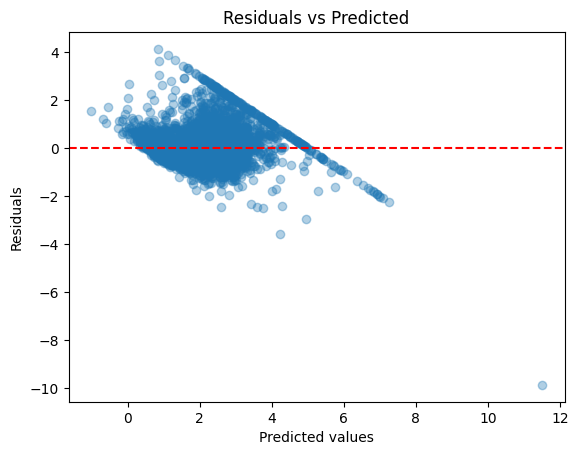

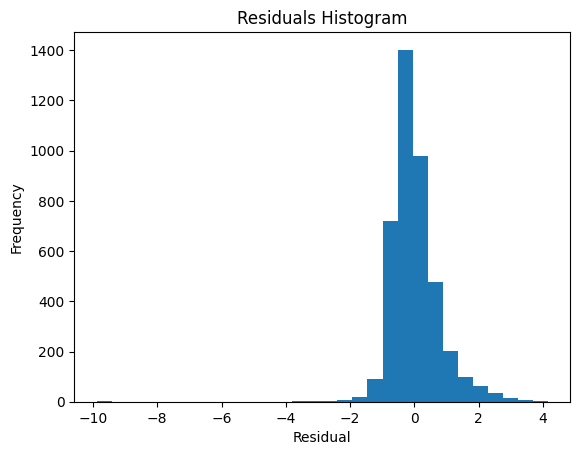

In [20]:
# ============================================================
# 11) Diagnostic plots (residuals)
# ============================================================
y_pred_best = ridge_cv.best_estimator_.predict(X_test)  # choose a model to inspect
resid = y_test - y_pred_best

plt.figure()
plt.scatter(y_pred_best, resid, alpha=0.35)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("Predicted values"); plt.ylabel("Residuals")
plt.title("Residuals vs Predicted")
plt.show()

plt.figure()
plt.hist(resid, bins=30)
plt.title("Residuals Histogram")
plt.xlabel("Residual"); plt.ylabel("Frequency")
plt.show()


In [21]:
# ============================================================
# 12) Heteroscedasticity test (Breusch–Pagan)
# ============================================================
# Use design matrix with constant
X_bp = sm.add_constant(X_test)
bp_stat = het_breuschpagan(resid, X_bp)
labels = ["LM Stat", "LM p-value", "F-Stat", "F p-value"]
print(dict(zip(labels, bp_stat)))


{'LM Stat': np.float64(2142.8263225357778), 'LM p-value': np.float64(0.0), 'F-Stat': np.float64(555.76381821912), 'F p-value': np.float64(0.0)}


In [22]:
# ============================================================
# 13) Polynomial features + GridSearchCV (best degree)
#     (Use Ridge to stabilize higher-degree coefs)
# ============================================================
poly_ridge = Pipeline([
    ("poly", PolynomialFeatures(include_bias=False)),
    ("scaler", StandardScaler()),
    ("ridge", Ridge())
])

param_grid = {
    "poly__degree": [1, 2, 3],
    "ridge__alpha": np.logspace(-2, 2, 5)
}

poly_cv = GridSearchCV(poly_ridge, param_grid, cv=3, scoring="r2", n_jobs=-1)
poly_cv.fit(X_train, y_train)

print("Best poly degree:", poly_cv.best_params_["poly__degree"])
print("Best alpha:", poly_cv.best_params_["ridge__alpha"])
summarize("Poly+Ridge (best)", poly_cv.best_estimator_, X_test, y_test)


Best poly degree: 1
Best alpha: 0.01
--- Poly+Ridge (best) ---
MAE : 0.5332000589081536
RMSE: 0.7455811358288168
R²  : 0.5757879873121596



In [23]:
# ============================================================
# 14) Brief coefficient interpretation
#     (Use baseline LinearRegression for direct coefficients)
# ============================================================
coef_series = pd.Series(lin_multi.coef_, index=X.columns).sort_values(key=np.abs, ascending=False)
print("Top 10 features by |coefficient| (baseline LinearRegression):")
print(coef_series.head(10))


Top 10 features by |coefficient| (baseline LinearRegression):
AveBedrms     0.783145
MedInc        0.448675
Longitude    -0.433708
Latitude     -0.419792
AveRooms     -0.123323
HouseAge      0.009724
AveOccup     -0.003526
Population   -0.000002
dtype: float64
